<a href="https://colab.research.google.com/github/renuka98/RPA_Performance_Evaluation/blob/master/baseline_loan_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning Keras


In [0]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#

Mounted at /content/drive


In [0]:

import numpy as np
from keras import preprocessing

MY_WORKSPACE_DIR = "/content/drive/My Drive/BPIC_Data/"

# add my working directory to the colab path
import sys
from sys import argv

sys.path.append(MY_WORKSPACE_DIR)

loan_data = pd.read_csv(MY_WORKSPACE_DIR +"train_output_data.csv", sep=",")

from sklearn.utils import shuffle
loan_data = shuffle(loan_data)

#mask = loan_data['Status'] == 'O_Refused'
#loan_data=loan_data[~mask]


loan_labels=loan_data['Status']
#drop all the columns in the data that may not be used
loan_data =  loan_data.drop(['ApplicationID', 'Status', 'OfferID'], axis=1)


dt_transformed = loan_data[['RequestedAmt','FirstWithdrawalAmount',	'MonthyCost',	'NumTerms',	'OfferedAmount',	'NumDays']]
mean = dt_transformed.mean(axis=0)
dt_transformed -= mean
std = dt_transformed.std(axis=0)
dt_transformed /= std
dt_cat = pd.get_dummies(loan_data[['Type','Goal','Resource']])
dt_transformed = pd.concat([dt_transformed, dt_cat], axis=1)
dt_transformed = dt_transformed.fillna(0)
dt_transformed.head(5)

print(loan_labels.value_counts())



O_Accepted     12178
O_Cancelled     7898
O_Refused       2824
Name: Status, dtype: int64


(36534, 134)
(29227, 134)
[9694 9811 9722]


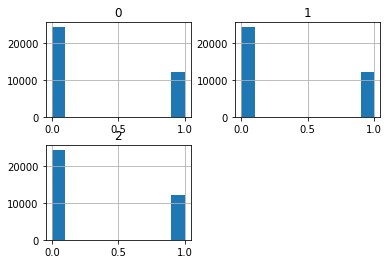

In [0]:
loan_Y =pd.get_dummies(loan_labels)

#from sklearn.preprocessing import LabelEncoder
#label_encoder = LabelEncoder()
#loan_Y = label_encoder.fit_transform(loan_labels)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(dt_transformed.values, loan_Y)
X_resampled, y_resampled = ros.fit_resample(dt_transformed.values, loan_Y.values)
df_resamp = pd.DataFrame(y_resampled)
df_resamp.hist()
print(np.shape(X_resampled))

from sklearn.model_selection import train_test_split
train_X, test_X, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

print(np.shape(train_X))
#print(loan_Y)
print(np.sum(train_labels, axis=0)) # print across each column
#test_labels.hist()

x_val = train_X[:3000]
partial_x_train = train_X[3000:]

y_val = train_labels[:3000]
partial_y_train = train_labels[3000:]

#y_val.hist()

Create all utility functions


In [0]:
from keras import models
from keras import layers
from keras import regularizers


model = models.Sequential()
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.0005), activation='relu', input_shape=(train_X.shape[1],)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))
model.add(layers.Dropout(0.1))
#model.add(layers.Dense(24, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))


from keras import losses
from keras import metrics
from keras import optimizers

#model.compile(optimizer=optimizers.RMSprop(lr=0.001),
model.compile(optimizer='adam',
    loss='categorical_crossentropy',  # binay_crossentropy
    metrics=['accuracy'])

print(model.summary())


history = model.fit(partial_x_train,
              partial_y_train, epochs=100, batch_size=256, validation_data=(x_val, y_val))

print(history)


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 64)                8640      
_________________________________________________________________
dropout_46 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_47 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 3)                 99        
Total params: 10,819
Trainable params: 10,819
Non-trainable params: 0
_________________________________________________________________
None
Train on 26227 samples, validate on 3000 samples
Epoch 1/100
26227/26227 [==============================] - 3s

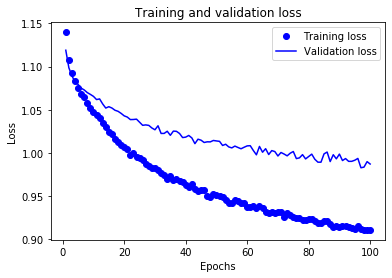

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[1 2 2 ... 1 0 1]
[[0 1 0]
 [1 0 0]
 [0 0 1]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
              precision    recall  f1-score   support

           0       0.43      0.71      0.53      2484
           1       0.61      0.30      0.40      2367
           2       0.66      0.55      0.60      2456

    accuracy                           0.52      7307
   macro avg       0.57      0.52      0.51      7307
weighted avg       0.56      0.52      0.51      7307

[[0.28079274 0.61754614 0.10166106]
 [0.2314058  0.20779979 0.5607944 ]
 [0.05268343 0.20259088 0.7447257 ]
 ...
 [0.20836298 0.5457505  0.24588653]
 [0.73102486 0.17863299 0.09034225]
 [0.23216686 0.68136805 0.0864651 ]]
(7307, 3)
Test Accuracy = 0.5221020938825783
Test Macro-F1 = 0.5114482791555024
Test Weighted-F1 = 0.512892572844273
[[1762  349  373]
 [1343  707  317]
 [1000  110 1346]]


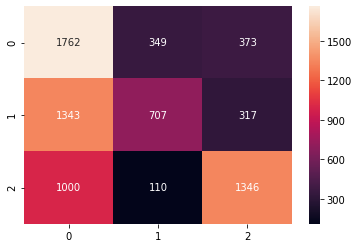

In [0]:
pred_y = model.predict(test_X)

apred_y = np.asarray(pred_y).round()

apred_y= np.argmax(apred_y, axis=1)
print(apred_y)

print(test_labels)
test_labels1 = np.argmax(test_labels,axis=1) # comment this line for binary

#Accuracy of the predicted values
from sklearn.metrics import classification_report
print(classification_report(test_labels1, apred_y)) # Precision , Recall, F1-Score & Support

from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(test_labels1, apred_y)
#print(cm)
# visualize the confusion matrix in a heat map
#df_cm = pd.DataFrame(cm)
#import seaborn as sns
#heatmap = sns.heatmap(df_cm, annot=True, fmt="d")


print(pred_y)
print(np.shape(test_labels))

from sklearn.metrics import f1_score, accuracy_score
test_acc = accuracy_score(test_labels1, apred_y)
test_f1_w = f1_score(test_labels1, apred_y, average='weighted')
test_f1_m = f1_score(test_labels1, apred_y, average='macro')

print("Test Accuracy = " + str(test_acc))
print("Test Macro-F1 = " + str(test_f1_m))
print("Test Weighted-F1 = " + str(test_f1_w))


from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(test_labels1, apred_y)
print(cm)
# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
import seaborn as sns
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

In [0]:
import xgboost
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#train_X, test_X, train_labels, test_labels
print(np.shape(train_X), np.shape(test_X), np.shape(train_labels) , np.shape(test_labels))
print(test_labels)
train_labelsT=np.argmax(train_labels, axis=1)
test_labelsT = np.argmax(test_labels, axis=1)
print(np.shape(test_labelsT), np.shape(train_labelsT))

search=True
param_grid = {
    'learning_rate': [0.01,0.05,0.08,0.2,0.8 ],
    'max_depth': [10,20,30],
    'subsample': [0.01,0.05,0.5,0.8],
    'colsample_bytree': [0.1, 0.5, 1.0],
    'min_child_weight': [1,3,5]
}

#best params after grid_search
#{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8}
            
if search==False:
    grid_search = GridSearchCV(estimator = xgboost.XGBClassifier(), param_grid = param_grid, 
                          scoring='roc_auc',cv = 3, n_jobs = -1, verbose = 2)

    grid_search.fit(train_X, train_labelsT)
    print(grid_search.best_params_)
    cls = grid_search.best_estimator_
else:
    cls = xgboost.XGBClassifier(colsample_bytree=0.5, learning_rate=0.05, max_depth=10, min_child_weight=1, subsample=0.8)
    cls.fit(train_X, train_labelsT)



(29227, 134) (7307, 134) (29227, 3) (7307, 3)
[[0 1 0]
 [1 0 0]
 [0 0 1]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
(7307,) (29227,)


(7307,) (7307,)
Test Accuracy = 0.6173532229369099
Test Macro-F1 = 0.6163918632454056
Test Weighted-F1 = 0.6164883029484949
[[1355  668  461]
 [ 560 1443  364]
 [ 360  383 1713]]


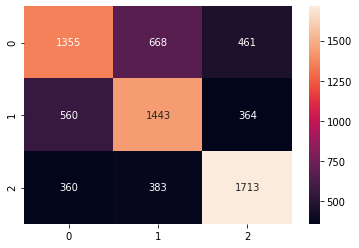

In [0]:
pred_yT =  cls.predict(test_X)
print(np.shape(pred_yT), np.shape(test_labelsT))

from sklearn.metrics import f1_score, accuracy_score

test_acc = accuracy_score(test_labelsT, pred_yT)
test_f1_w = f1_score(test_labelsT, pred_yT, average='weighted')
test_f1_m = f1_score(test_labelsT, pred_yT, average='macro')

print("Test Accuracy = " + str(test_acc))
print("Test Macro-F1 = " + str(test_f1_m))
print("Test Weighted-F1 = " + str(test_f1_w))


from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(test_labelsT, pred_yT)
print(cm)
# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
import seaborn as sns
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")